In [1]:
import sys, os, random, numpy as np, tensorflow as tf
import matplotlib.pyplot as plt

print("Python:", sys.version)
print("TensorFlow:", tf.__version__)

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# (Optional) Better CuDNN determinism (slower but stable)
os.environ["TF_DETERMINISTIC_OPS"] = "1"


Python: 3.13.0 (main, Oct  7 2024, 05:02:14) [Clang 16.0.0 (clang-1600.0.26.4)]
TensorFlow: 2.20.0


In [2]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences

vocab_size = 5000  # keep top 5k words
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=vocab_size)

print("Number of training samples:", len(y_train))
print("Number of positive samples:", int(np.sum(y_train)))
print("Number of test samples:", len(y_test))

# Peek at a single review (as integer ids)
print("First training sample (ids):")
print(X_train[0][:50], "...(truncated)")


17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Number of training samples: 25000
Number of positive samples: 12500
Number of test samples: 25000
First training sample (ids):
[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447] ...(truncated)


In [3]:
# Cell 3 — Map ids back to words (for sanity check)
word_index = imdb.get_word_index()
index_word = {idx + 3: w for w, idx in word_index.items()}
index_word[0] = "<PAD>"
index_word[1] = "<START>"
index_word[2] = "<UNK>"
index_word[3] = "<UNUSED>"

decoded = [index_word.get(i, "<UNK>") for i in X_train[0]]
print("Decoded first review (truncated to 80 tokens):")
print(" ".join(decoded[:80]), "...(truncated)")


1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Decoded first review (truncated to 80 tokens):
<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as ...(truncated)


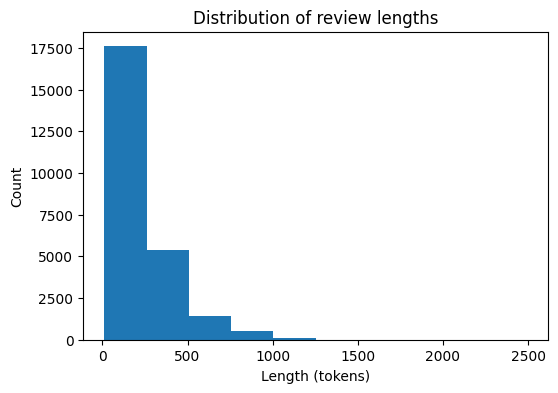

X_train shape after padding: (25000, 200)
X_test  shape after padding: (25000, 200)


In [4]:
review_lengths = [len(x) for x in X_train]
plt.figure(figsize=(6,4))
plt.hist(review_lengths, bins=10)
plt.title("Distribution of review lengths")
plt.xlabel("Length (tokens)")
plt.ylabel("Count")
plt.show()

maxlen = 200  # as per assignment
X_train = pad_sequences(X_train, maxlen=maxlen)
X_test  = pad_sequences(X_test,  maxlen=maxlen)
print("X_train shape after padding:", X_train.shape)
print("X_test  shape after padding:", X_test.shape)


In [5]:
from tensorflow.keras import layers, models

tf.random.set_seed(SEED)

embedding_size = 32
model_simple = models.Sequential([
    layers.Embedding(vocab_size, embedding_size, input_length=maxlen),
    layers.LSTM(50),
    layers.Dense(1, activation='sigmoid')
])

model_simple.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
model_simple.summary()


/Users/jaahanavajoshi/Documents/GitHub/Talha/.venv/lib/python3.13/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [6]:
batch_size = 64
n_epoch = 3   # increase if you have GPU/time

history_simple = model_simple.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=n_epoch,
    validation_data=(X_test, y_test),
    verbose=1
)

test_acc_simple = model_simple.evaluate(X_test, y_test, verbose=0)[1]
print("Test accuracy (simple LSTM):", test_acc_simple)


Epoch 1/3


2025-10-21 19:43:12.447825: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


390/391 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.6997 - loss: 0.5312

2025-10-21 19:43:32.333264: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


391/391 ━━━━━━━━━━━━━━━━━━━━ 25s 62ms/step - accuracy: 0.7950 - loss: 0.4199 - val_accuracy: 0.8503 - val_loss: 0.3486
Epoch 2/3
391/391 ━━━━━━━━━━━━━━━━━━━━ 24s 61ms/step - accuracy: 0.8854 - loss: 0.2846 - val_accuracy: 0.8551 - val_loss: 0.3751
Epoch 3/3
391/391 ━━━━━━━━━━━━━━━━━━━━ 24s 61ms/step - accuracy: 0.9009 - loss: 0.2497 - val_accuracy: 0.8608 - val_loss: 0.3296


2025-10-21 19:44:25.327017: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


Test accuracy (simple LSTM): 0.8608400225639343


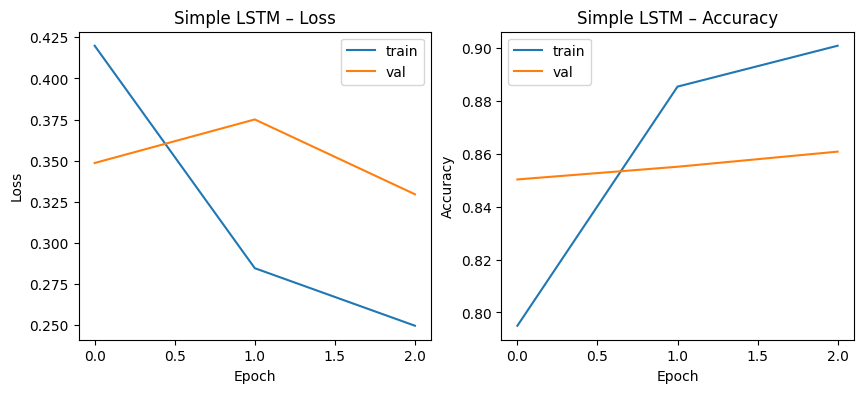

In [7]:
def plot_keras_history(hist, title_prefix=""):
    fig, ax = plt.subplots(1,2, figsize=(10,4))
    ax[0].plot(hist.history['loss'], label='train')
    ax[0].plot(hist.history['val_loss'], label='val')
    ax[0].set_title(f"{title_prefix}Loss"); ax[0].set_xlabel("Epoch"); ax[0].set_ylabel("Loss"); ax[0].legend()
    ax[1].plot(hist.history['accuracy'], label='train')
    ax[1].plot(hist.history['val_accuracy'], label='val')
    ax[1].set_title(f"{title_prefix}Accuracy"); ax[1].set_xlabel("Epoch"); ax[1].set_ylabel("Accuracy"); ax[1].legend()
    plt.show()

plot_keras_history(history_simple, "Simple LSTM – ")


In [8]:
from tensorflow.keras import optimizers

tf.random.set_seed(SEED)

model_stacked = models.Sequential([
    layers.Embedding(vocab_size, embedding_size, input_length=maxlen),
    layers.LSTM(50, return_sequences=True, dropout=0.2),
    layers.LSTM(50, dropout=0.2),
    layers.Dense(1, activation='sigmoid')
])

# use modern argument name "learning_rate"
optimizer = optimizers.Adam(learning_rate=0.003)
model_stacked.compile(
    loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)
model_stacked.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/7


2025-10-21 19:44:31.819472: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.6537 - loss: 0.6053

2025-10-21 19:45:13.541709: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


391/391 ━━━━━━━━━━━━━━━━━━━━ 53s 131ms/step - accuracy: 0.7338 - loss: 0.5260 - val_accuracy: 0.8399 - val_loss: 0.3945
Epoch 2/7
391/391 ━━━━━━━━━━━━━━━━━━━━ 49s 125ms/step - accuracy: 0.8647 - loss: 0.3253 - val_accuracy: 0.8479 - val_loss: 0.4165
Epoch 3/7
391/391 ━━━━━━━━━━━━━━━━━━━━ 51s 130ms/step - accuracy: 0.8971 - loss: 0.2625 - val_accuracy: 0.8623 - val_loss: 0.3215
Epoch 4/7
391/391 ━━━━━━━━━━━━━━━━━━━━ 52s 133ms/step - accuracy: 0.9137 - loss: 0.2248 - val_accuracy: 0.8717 - val_loss: 0.3178
Epoch 5/7
391/391 ━━━━━━━━━━━━━━━━━━━━ 52s 134ms/step - accuracy: 0.9260 - loss: 0.1938 - val_accuracy: 0.8692 - val_loss: 0.3308
Epoch 6/7
391/391 ━━━━━━━━━━━━━━━━━━━━ 49s 126ms/step - accuracy: 0.9370 - loss: 0.1677 - val_accuracy: 0.8739 - val_loss: 0.3670
Epoch 7/7
391/391 ━━━━━━━━━━━━━━━━━━━━ 49s 127ms/step - accuracy: 0.9452 - loss: 0.1485 - val_accuracy: 0.8646 - val_loss: 0.4099


2025-10-21 19:50:27.714220: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


Test accuracy (stacked LSTM): 0.8646399974822998


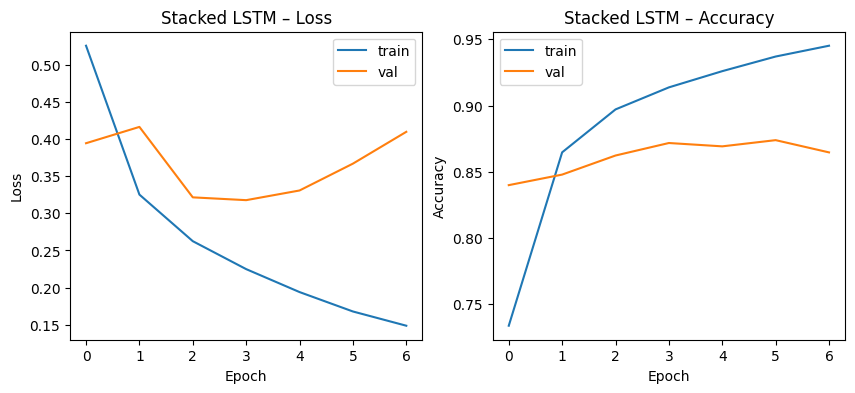

In [9]:
n_epoch_stacked = 7  # reduce if on CPU
history_stacked = model_stacked.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=n_epoch_stacked,
    validation_data=(X_test, y_test),
    verbose=1
)

test_acc_stacked = model_stacked.evaluate(X_test, y_test, verbose=0)[1]
print("Test accuracy (stacked LSTM):", test_acc_stacked)
plot_keras_history(history_stacked, "Stacked LSTM – ")


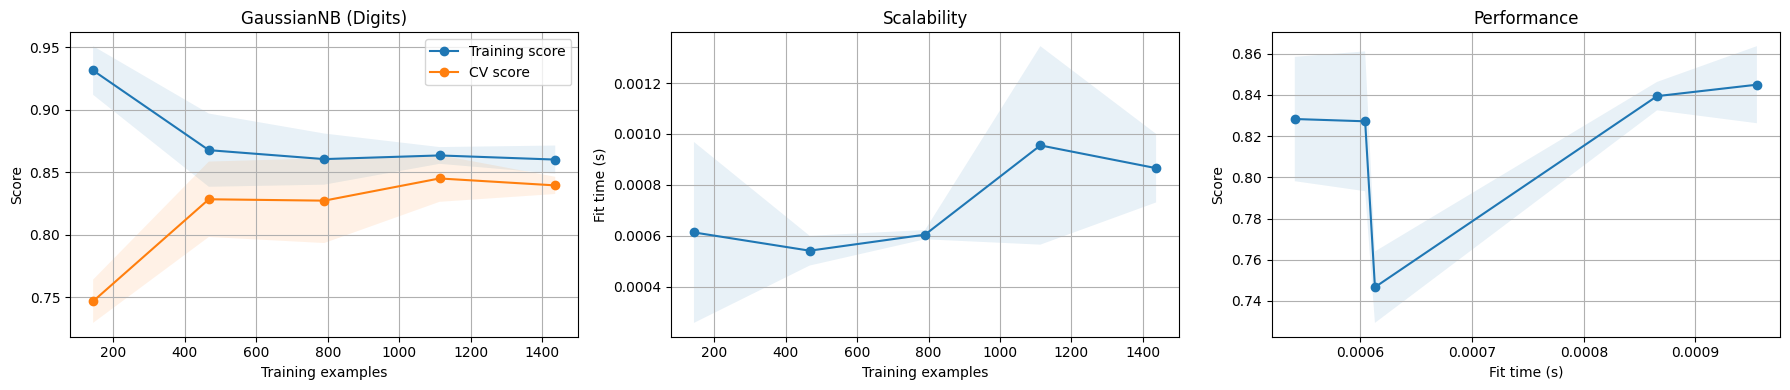

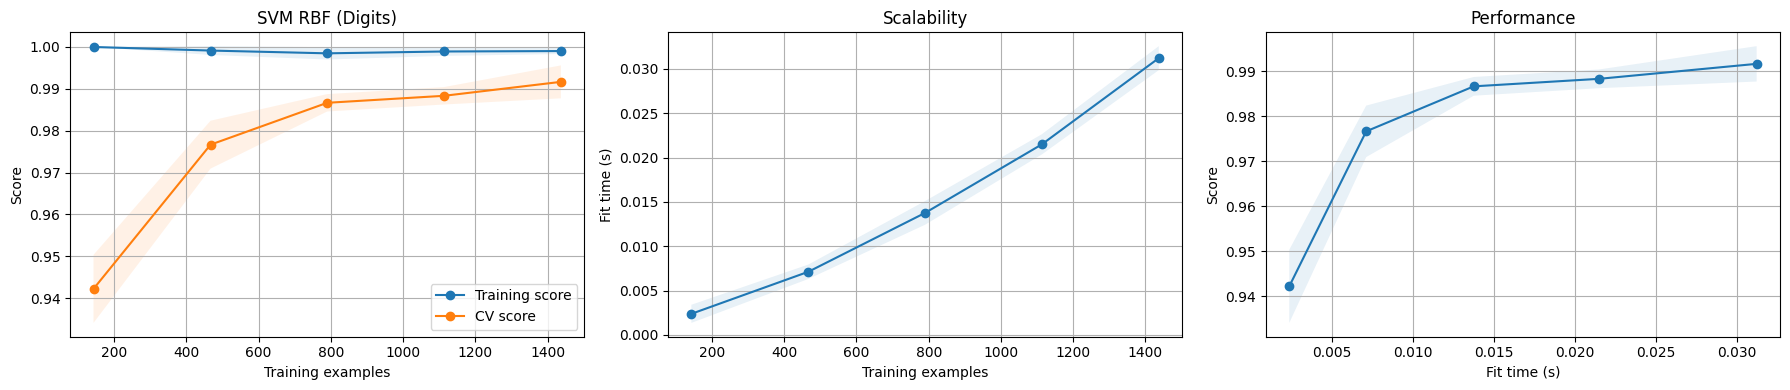

In [10]:
from sklearn.datasets import load_digits
from sklearn.model_selection import ShuffleSplit, learning_curve
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# Use a classic tabular dataset to reproduce the 3-panel learning curve diagram
digits = load_digits()
X, y = digits.data, digits.target

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=SEED)

def plot_learning_curve_triptych(estimator, title, X, y, cv, n_jobs=None,
                                 train_sizes=np.linspace(0.1, 1.0, 5)):
    fig, axes = plt.subplots(1, 3, figsize=(18, 4))
    axes[0].set_title(title)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, return_times=True
    )
    train_mean = np.mean(train_scores, axis=1)
    train_std  = np.std(train_scores, axis=1)
    test_mean  = np.mean(test_scores, axis=1)
    test_std   = np.std(test_scores, axis=1)
    ft_mean    = np.mean(fit_times, axis=1)
    ft_std     = np.std(fit_times, axis=1)

    # Panel 1 — Learning curve
    axes[0].grid(True)
    axes[0].fill_between(train_sizes, train_mean-train_std, train_mean+train_std, alpha=0.1)
    axes[0].fill_between(train_sizes, test_mean-test_std,   test_mean+test_std,   alpha=0.1)
    axes[0].plot(train_sizes, train_mean, "o-", label="Training score")
    axes[0].plot(train_sizes, test_mean,  "o-", label="CV score")
    axes[0].legend(loc="best")

    # Panel 2 — Scalability (n_samples vs fit time)
    axes[1].grid(True)
    axes[1].plot(train_sizes, ft_mean, "o-")
    axes[1].fill_between(train_sizes, ft_mean-ft_std, ft_mean+ft_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("Fit time (s)")
    axes[1].set_title("Scalability")

    # Panel 3 — Performance vs fit time
    order = np.argsort(ft_mean)
    axes[2].grid(True)
    axes[2].plot(ft_mean[order], test_mean[order], "o-")
    axes[2].fill_between(ft_mean[order], test_mean[order]-test_std[order],
                         test_mean[order]+test_std[order], alpha=0.1)
    axes[2].set_xlabel("Fit time (s)")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance")
    plt.tight_layout()
    plt.show()

# Gaussian Naive Bayes
plot_learning_curve_triptych(GaussianNB(), "GaussianNB (Digits)", X, y, cv=cv)

# Support Vector Machine (RBF kernel)
plot_learning_curve_triptych(SVC(gamma=0.001), "SVM RBF (Digits)", X, y, cv=cv)


In [12]:
print("\n================ Model Performance Summary ================")
print(f"Simple LSTM Test Accuracy : {test_acc_simple:.4f}")
print(f"Stacked LSTM Test Accuracy: {test_acc_stacked:.4f}")

print("\nModel architectures:")
print("------------------------------------------------------------")
print("Simple LSTM:")
model_simple.summary()
print("------------------------------------------------------------")
print("Stacked LSTM:")
model_stacked.summary()
print("============================================================")



================ Model Performance Summary ================
Simple LSTM Test Accuracy : 0.8608
Stacked LSTM Test Accuracy: 0.8646

Model architectures:
------------------------------------------------------------
Simple LSTM:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 200, 32)        │       160,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 50)             │        16,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 529,955 (2.02 MB)

 Trainable params: 176,651 (690.04 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 353,304 (1.35 MB)

------------------------------------------------------------
Stacked LSTM:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 200, 32)        │       160,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 200, 50)        │        16,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 590,555 (2.25 MB)

 Trainable params: 196,851 (768.95 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 393,704 (1.50 MB)

In [13]:
pred_probs = model_stacked.predict(X_test[:10]).flatten()
preds = (pred_probs >= 0.5).astype(int)

print("\n================ Sample Predictions ================")
for i, (p, prob, true) in enumerate(zip(preds, pred_probs, y_test[:10])):
    sentiment = "Positive" if p == 1 else "Negative"
    true_label = "Positive" if true == 1 else "Negative"
    print(f"Sample {i+1:02d} | Predicted: {sentiment:<8} (p={prob:.3f}) | True: {true_label}")
print("====================================================")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step

================ Sample Predictions ================
Sample 01 | Predicted: Negative (p=0.007) | True: Negative
Sample 02 | Predicted: Positive (p=0.997) | True: Positive
Sample 03 | Predicted: Negative (p=0.005) | True: Positive
Sample 04 | Predicted: Positive (p=0.624) | True: Negative
Sample 05 | Predicted: Positive (p=0.999) | True: Positive
Sample 06 | Predicted: Positive (p=0.766) | True: Positive
Sample 07 | Predicted: Positive (p=0.966) | True: Positive
Sample 08 | Predicted: Negative (p=0.005) | True: Negative
Sample 09 | Predicted: Positive (p=0.996) | True: Negative
Sample 10 | Predicted: Positive (p=0.998) | True: Positive


2025-10-21 19:50:45.541817: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
